In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
PATH = "train.csv"
df = pd.read_csv(PATH)

# Vista rápida
print(df.shape)      
print(df.head(3))
df.info()

(7613, 5)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target  
0       1  
1       1  
2       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


target
0    4342
1    3271
Name: count, dtype: int64


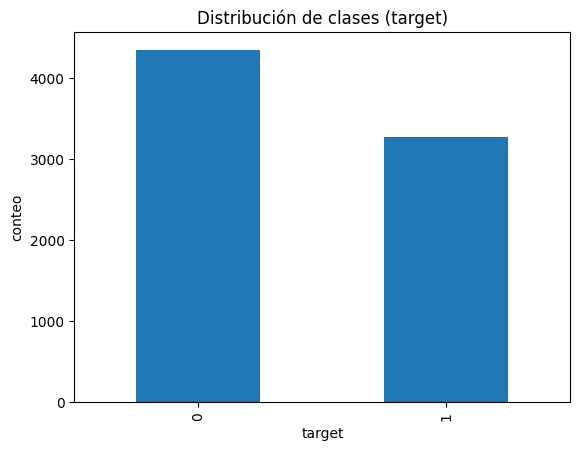

In [3]:
clase_counts = df['target'].value_counts().sort_index()
print(clase_counts)

# Grafiquita simple
plt.figure()
clase_counts.plot(kind='bar')
plt.title('Distribución de clases (target)')
plt.xlabel('target')
plt.ylabel('conteo')
plt.show()


In [4]:
missing_values = df.isnull().sum()
print(missing_values)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


count    7613.000000
mean      101.161697
std        33.854073
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: tweet_length, dtype: float64


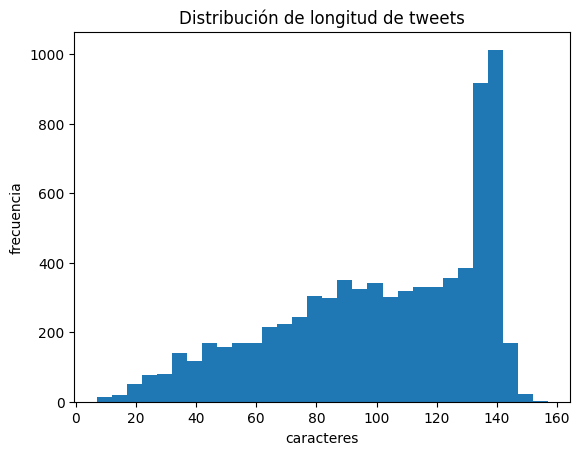

In [5]:
df['tweet_length'] = df['text'].astype(str).apply(len)
print(df['tweet_length'].describe())

plt.figure()
plt.hist(df['tweet_length'], bins=30)
plt.title('Distribución de longitud de tweets')
plt.xlabel('caracteres')
plt.ylabel('frecuencia')
plt.show()

Palabras mas frecuentes por categroia

In [6]:
# Tokenización básica
token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z]+\b'  # palabras con ≥2 letras

cv = CountVectorizer(lowercase=True, token_pattern=token_pattern)

def top_words_for_class(df, clase, topk=20):
    textos = df.loc[df['target'] == clase, 'text'].astype(str).tolist()
    X = cv.fit_transform(textos)
    sums = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(cv.get_feature_names_out())
    top_idx = np.argsort(sums)[::-1][:topk]
    return pd.DataFrame({
        'palabra': vocab[top_idx],
        'frecuencia': sums[top_idx]
    })

top_0 = top_words_for_class(df, 0, topk=25)
top_1 = top_words_for_class(df, 1, topk=25)

print("Top palabras en tweets NO desastre (target=0):")
print(top_0)

print("\nTop palabras en tweets de DESASTRE (target=1):")
print(top_1)

Top palabras en tweets NO desastre (target=0):
   palabra  frecuencia
0       co        2212
1     http        1927
2      the        1913
3       to        1192
4      and         920
5       of         902
6       in         822
7      you         757
8       is         598
9       my         546
10      it         539
11     for         493
12      on         440
13    that         413
14    with         380
15    this         298
16      be         287
17   https         277
18      me         263
19    like         254
20      by         249
21      so         243
22    have         242
23     are         237
24    just         234

Top palabras en tweets de DESASTRE (target=1):
   palabra  frecuencia
0       co        2528
1     http        2382
2      the        1364
3       in        1164
4       of         928
5       to         757
6      and         506
7       on         420
8      for         401
9       is         352
10      at         308
11      by         278
12    fr

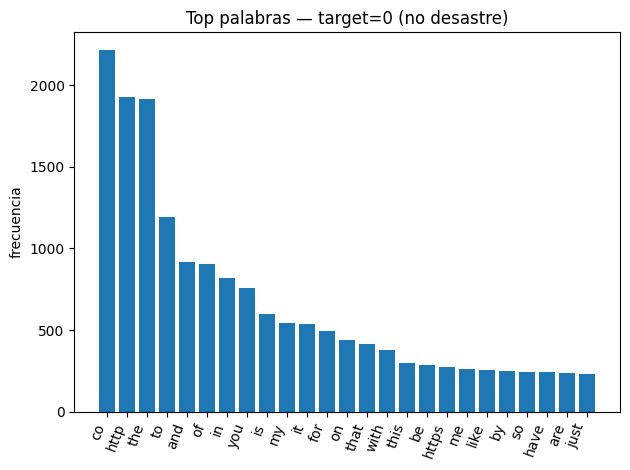

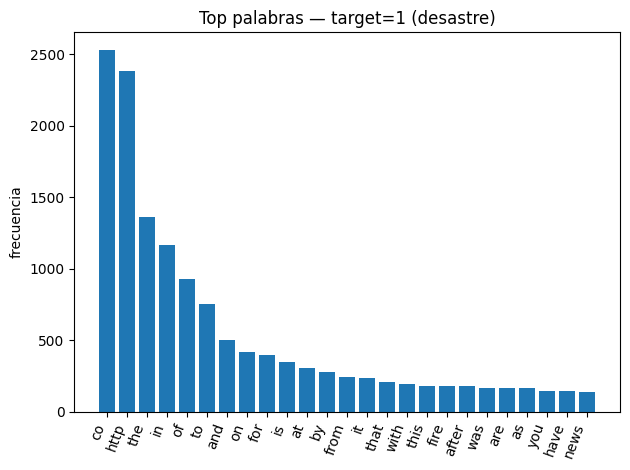

In [7]:
def plot_top(df_top, title):
    plt.figure()
    plt.bar(df_top['palabra'], df_top['frecuencia'])
    plt.title(title)
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('frecuencia')
    plt.tight_layout()
    plt.show()

plot_top(top_0, 'Top palabras — target=0 (no desastre)')
plot_top(top_1, 'Top palabras — target=1 (desastre)')


Nube de palabras

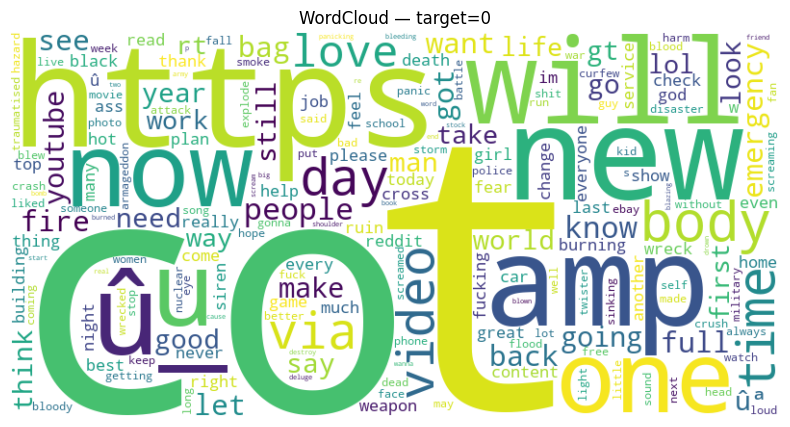

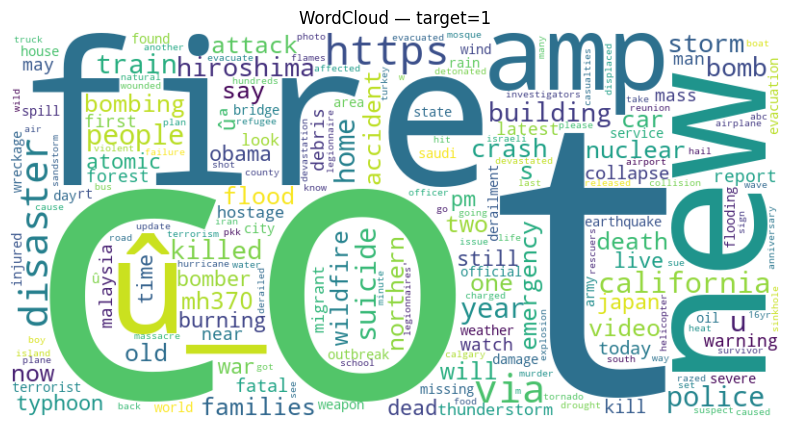

In [9]:
from wordcloud import WordCloud

def wordcloud_for_class(df, clase, max_words=150):
    textos = " ".join(df.loc[df['target']==clase, 'text'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white',
                   collocations=False).generate(textos.lower())
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud — target={clase}')
    plt.show()

wordcloud_for_class(df, 0)
wordcloud_for_class(df, 1)


In [10]:
def top_ngrams_for_class(df, clase, n=2, topk=20):
    cv_ng = CountVectorizer(lowercase=True, token_pattern=token_pattern, ngram_range=(n, n))
    textos = df.loc[df['target']==clase, 'text'].astype(str).tolist()
    X = cv_ng.fit_transform(textos)
    sums = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(cv_ng.get_feature_names_out())
    top_idx = np.argsort(sums)[::-1][:topk]
    return pd.DataFrame({'ngram': vocab[top_idx], 'frecuencia': sums[top_idx]})

top_bigram_0 = top_ngrams_for_class(df, 0, n=2, topk=20)
top_bigram_1 = top_ngrams_for_class(df, 1, n=2, topk=20)

print("Top bigramas target=0:\n", top_bigram_0)
print("\nTop bigramas target=1:\n", top_bigram_1)

Top bigramas target=0:
          ngram  frecuencia
0      http co        1924
1     https co         276
2      co http         221
3       in the         164
4       of the         137
5       to the          90
6       on the          78
7        to be          73
8       co via          66
9      for the          64
10      if you          59
11      you re          58
12    going to          48
13      is the          48
14      at the          43
15     and the          41
16  cross body          39
17     will be          38
18     want to          38
19     you are          38

Top bigramas target=1:
                   ngram  frecuencia
0               http co        2382
1               co http         198
2                in the         145
3              https co         134
4                of the         119
5                co via          72
6        suicide bomber          59
7                on the          51
8                at the          43
9             more than 

In [11]:
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk import download
from nltk.stem import WordNetLemmatizer

try:
    _ = stopwords.words('english')
except LookupError:
    download('stopwords')
try:
    _ = WordNetLemmatizer()
    download('wordnet')
    download('omw-1.4')
except:
    pass

EN_STOP = set(stopwords.words('english'))
for w in ['no', 'not', "nor", "n't"]:
    if w in EN_STOP:
        EN_STOP.remove(w)

lemmatizer = WordNetLemmatizer()

RE_URL = re.compile(r'https?://\S+|www\.\S+')
RE_MENTION = re.compile(r'@\w+')
# Conserva la palabra del hashtag: "#earthquake" -> "earthquake"
RE_HASHTAG = re.compile(r'#')
# Apóstrofes “rectos” y “curvos”
RE_APOS = re.compile(r"[’‘´`']")
# Emoticones ASCII comunes
RE_EMOTICONS = re.compile(r'(:\)|:-\)|:\(|:-\(|;-\)|;\)|:D|:-D|:\||:-\||:\]|:\[|:P|:-P|<3)')
# Emojis (rangos Unicode habituales)
RE_EMOJI = re.compile(
    "["
    "\U0001F1E0-\U0001F1FF"  # banderas
    "\U0001F300-\U0001F5FF"  # símbolos y pictos
    "\U0001F600-\U0001F64F"  # emoticonos
    "\U0001F680-\U0001F6FF"  # transporte
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FA6F"
    "\U00002700-\U000027BF"  # dingbats
    "]+",
    flags=re.UNICODE,
)
# Puntuación (usaremos translate, pero dejamos regex de apoyo)
RE_NONALPHANUM = re.compile(r'[^a-z0-9\s]')

def preprocess_text(
    text: str,
    lowercase: bool = True,
    remove_urls: bool = True,
    remove_mentions: bool = True,
    strip_hashtag_symbol: bool = True,
    remove_emoticons_emojis: bool = True,
    remove_punct: bool = True,
    remove_numbers: bool = True,
    keep_911: bool = True,
    remove_stopwords: bool = True,
    lemmatize: bool = False,
) -> str:
    """
    Limpia y normaliza un tweet siguiendo las tareas del laboratorio (punto 3.1).
    """

    if not isinstance(text, str):
        text = str(text)

    # 1) Minúsculas
    if lowercase:
        text = text.lower()

    # 2) Quitar URLs
    if remove_urls:
        text = RE_URL.sub(' ', text)

    # 3) Quitar menciones (o al menos el @)
    if remove_mentions:
        text = RE_MENTION.sub(' ', text)

    # 4) Quitar símbolo '#' pero conservar la palabra del hashtag
    if strip_hashtag_symbol:
        text = RE_HASHTAG.sub('', text)

    # 5) Normalizar/quitar apóstrofes (don't -> dont)
    text = RE_APOS.sub('', text)

    # 6) Quitar emoticones/emojis
    if remove_emoticons_emojis:
        text = RE_EMOTICONS.sub(' ', text)
        text = RE_EMOJI.sub(' ', text)

    # 7) Quitar puntuación
    if remove_punct:
        # translate es muy rápido para puntuación ASCII
        text = text.translate(str.maketrans('', '', string.punctuation))
        # limpiar cualquier resto no alfanumérico
        text = RE_NONALPHANUM.sub(' ', text)

    # 8) Quitar números (con opción de conservar el token '911')
    if remove_numbers:
        if keep_911:
            # Marcamos '911' para conservarlo
            text = re.sub(r'\b911\b', ' keepnineoneone ', text)
        text = re.sub(r'\d+', ' ', text)
        if keep_911:
            text = text.replace('keepnineoneone', '911')

    # 9) Tokenizar por espacios, quitar espacios extra
    tokens = [tok for tok in text.split() if tok]

    # 10) Quitar stopwords
    if remove_stopwords:
        tokens = [t for t in tokens if t not in EN_STOP]

    # 11) Lematizar (opcional)
    if lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)

# --- 4) Aplicar a tu DataFrame (ajusta la ruta de tu CSV si hace falta) ---
df['text_clean'] = df['text'].apply(preprocess_text)

# Vista rápida de antes/después
print(df[['text', 'text_clean']].head(8).to_string(index=False))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jemil\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jemil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jemil\AppData\Roaming\nltk_data...


                                                                                                                                 text                                                                                  text_clean
                                                                Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                deeds reason earthquake may allah forgive us
                                                                                               Forest fire near La Ronge Sask. Canada                                                       forest fire near la ronge sask canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected residents asked shelter place notified officers no evacuation shelter place orders expected
                                                                    13,000 people receive #wildf

In [12]:
from collections import Counter

def top_k_words(series, k=20):
    c = Counter()
    for s in series:
        c.update(s.split())
    return pd.DataFrame(c.most_common(k), columns=['palabra', 'frecuencia'])

top0 = top_k_words(df.loc[df.target==0, 'text_clean'], k=25)
top1 = top_k_words(df.loc[df.target==1, 'text_clean'], k=25)

print("\nTop palabras limpias — target=0\n", top0)
print("\nTop palabras limpias — target=1\n", top1)



Top palabras limpias — target=0
       palabra  frecuencia
0        like         253
1          im         244
2         not         204
3         amp         193
4         new         171
5         get         163
6          no         146
7        dont         141
8         one         129
9        body         113
10        via          99
11      would          97
12      video          96
13       love          90
14     people          90
15         us          86
16       know          85
17       time          84
18        got          84
19       back          84
20        see          82
21       full          82
22        day          81
23       cant          81
24  emergency          81

Top palabras limpias — target=1
        palabra  frecuencia
0         fire         180
1         news         144
2          via         121
3     disaster         117
4   california         111
5      suicide         110
6          amp         109
7           no         108
8       polic